In [138]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer
import matplotlib.pyplot as plt

In [139]:
df = pd.read_csv("car_sales_data.csv")

In [140]:
print("First five rows: \n")
df.head()

First five rows: 



,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [141]:
print("Data informations: \n")
df.info()

Data informations: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [142]:
print("Data descriptions: \n")
df.describe()

Data descriptions: 



,Engine size,Year of manufacture,Mileage,Price
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.773058,2004.209440,112497.320700,13828.903160
std,0.734108,9.645965,71632.515602,16416.681336
min,1.000000,1984.000000,630.000000,76.000000
25%,1.400000,1996.000000,54352.250000,3060.750000
50%,1.600000,2004.000000,100987.500000,7971.500000
75%,2.000000,2012.000000,158601.000000,19026.500000
max,5.000000,2022.000000,453537.000000,168081.000000


In [143]:
df_encoded = pd.get_dummies(df, columns=["Fuel type", "Manufacturer", "Model"], drop_first=True)

X = df_encoded.drop(columns=["Price"])
y = df_encoded["Price"]

X[["Year of manufacture"]] = 2025 - X[["Year of manufacture"]]
X = X.rename(columns={'Year of manufacture': 'Age of car'})


X[["Engine size", "Mileage", "Age of car"]] = ((X[["Engine size", "Mileage", "Age of car"]] - X[["Engine size", "Mileage", "Age of car"]].mean()) /
                                               X[["Engine size", "Mileage", "Age of car"]].std())
y = (y - y.mean()) / y.std()

In [144]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
transformer = SymbolicTransformer(generations=20,
                         population_size=2000,
                         hall_of_fame=100,
                         n_components=10,
                         # function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9,
                         verbose=1,
                         random_state=0,
                         n_jobs=3)

transformer.fit(X, y)
#
# X_new = transformer.fit_transform(X, y)
# X = np.hstack((X, X_new))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    24.89         0.127647        3         0.743682          0.73899      1.42m
   1    13.26         0.433309        7         0.813833         0.813464     45.19s
   2     8.81          0.57066        9         0.820606         0.823266     37.97s
   3    10.73         0.624802       17         0.861152         0.866842     35.72s
   4    10.66         0.657025       27         0.909181         0.910092     33.22s
   5    16.22         0.696481       37         0.949139         0.950062      1.06m
   6    24.64         0.718474       49         0.952415         0.954392     32.66s
   7    30.94         0.753082       75         0.957758         0.956447     31.94s
   8    31.41         0.778108       59         0.966899         0.970077  

SymbolicTransformer(max_samples=0.9, n_jobs=3, parsimony_coefficient=0.0005,
                    population_size=2000, random_state=0, verbose=1)

In [145]:
# X = pd.DataFrame(X)

In [146]:
X.head()

,Engine size,Age of car,Mileage,Fuel type_Hybrid,Fuel type_Petrol,Manufacturer_Ford,Manufacturer_Porsche,Manufacturer_Toyota,Manufacturer_VW,Model_911,...,Model_Golf,Model_M5,Model_Mondeo,Model_Passat,Model_Polo,Model_Prius,Model_RAV4,Model_X3,Model_Yaris,Model_Z4
0,-1.053058,0.229053,0.206647,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3.033535,-1.222331,-0.762884,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.235739,-1.014990,-1.023381,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,0.036700,1.680437,1.372515,True,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4,-1.053058,-0.185628,0.214591,False,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False


In [147]:
y.head()

0   -0.655120
1    2.185283
2    0.623944
3   -0.738511
4   -0.592562
Name: Price, dtype: float64

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [149]:
est_gp = SymbolicRegressor(
    population_size=5000,
    generations=30,
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    tournament_size=20,
    parsimony_coefficient=0.001,
    stopping_criteria=0.01,
    metric='mse',
    n_jobs=-1,
    random_state=42
)

est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    25.84            54092        3         0.498651         0.479141      1.68m
   1     5.70          1.77366        3         0.491568         0.542886      1.19m
   2     5.57          3.75668        7         0.449306         0.508833      1.15m
   3     4.73          1.86042       11         0.419343         0.399007      1.17m
   4     5.12          1.70553       15         0.400603          0.40887      1.15m
   5     6.76          2.09507       19          0.33982         0.345614      1.93m
   6     9.35          1.40706       21         0.326349         0.337291      1.09m
   7    12.58           3.4851       29         0.315418         0.316788      1.10m
   8    15.92           5.4105       39         0.280709           0.2754  

SymbolicRegressor(generations=30, max_samples=0.9, metric='mse', n_jobs=-1,
                  p_crossover=0.7, p_hoist_mutation=0.1, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, population_size=5000, random_state=42,
                  stopping_criteria=0.01, verbose=1)

In [150]:
y_pred_train = pd.Series(est_gp.predict(X_train), index=X_train.index)
y_pred_train.head()

18306   -0.558359
49528    0.040015
44745    0.445538
46827    0.529915
27531    0.752693
dtype: float64

In [151]:
y_train.head()

18306   -0.628136
49528   -0.457334
44745    0.530625
46827    0.677183
27531    0.580818
Name: Price, dtype: float64

In [152]:
y_pred_test = pd.Series(est_gp.predict(X_test), index=X_test.index)
y_pred_test.head()

33553    2.579889
9427     1.449221
199      0.491430
12447   -0.346275
39489   -0.455278
dtype: float64

In [153]:
y_test.head()

33553    3.336125
9427     1.306421
199      0.215701
12447   -0.646653
39489   -0.548034
Name: Price, dtype: float64

In [135]:
print("R2 Score of Train Samples: ", est_gp.score(X_train, y_train))
print("R2 Score of Test Samples: ", est_gp.score(X_test, y_test))

R2 Score of Train Samples:  0.9263375651005588
R2 Score of Test Samples:  0.9264886747445601


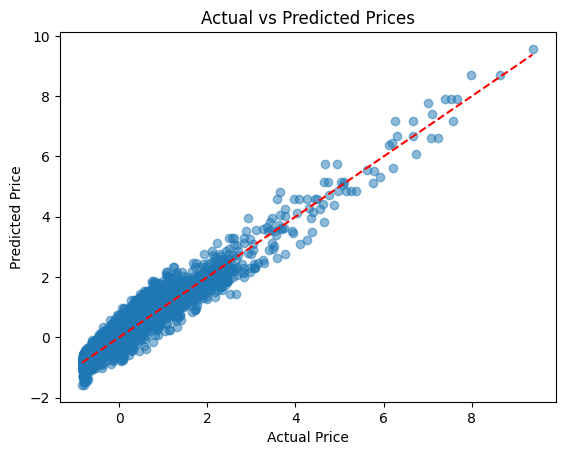

In [136]:
# Toplam örnek sayısı
n = len(y_train)

# Rastgele 1000 indeks seç (tekrarsız)
idx = np.random.choice(n, size=5000, replace=False)

# Alt küme oluştur
y_train_sample = y_train.iloc[idx] if hasattr(y_train, "iloc") else y_train[idx]
y_pred_sample = y_pred_train.iloc[idx] if hasattr(y_pred_train, "iloc") else y_pred_train[idx]

# Scatter plot
plt.scatter(y_train_sample, y_pred_sample, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

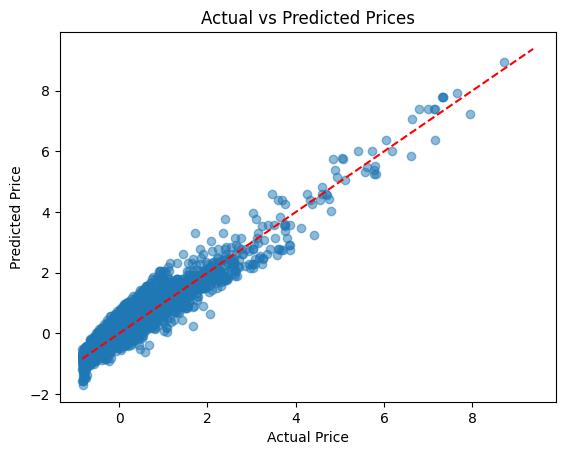

In [137]:
# Toplam örnek sayısı
n = len(y_test)

# Rastgele 1000 indeks seç (tekrarsız)
idx = np.random.choice(n, size=5000, replace=False)

# Alt küme oluştur
y_test_sample = y_test.iloc[idx] if hasattr(y_test, "iloc") else y_test[idx]
y_pred_sample = y_pred_test.iloc[idx] if hasattr(y_pred_test, "iloc") else y_pred_test[idx]

# Scatter plot
plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()